In [131]:
import math
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import lines
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import & Preprocess Data

In [132]:
data = pd.read_csv('../data/master_reduced.csv')
data = data[data.columns.difference(['year', 'data_year', 'cfips', 'county', 'state'])]
data.head()

,birth_rate,median_age,median_hh_inc,microbusiness_density,pct_broadband,pct_college,pct_divorced,pct_employed_at_government,pct_employed_at_self_employed,pct_house_price_250k_500k,...,pct_housing_single_detached,pct_in_arts_industry,pct_in_finance_industry,pct_in_it_industry,pct_insured,pct_moved_from_abroad,pct_moved_within_state,pct_with_libarts_degree,pct_with_scieng_degree,total_population
0,71,37.8,55317,2.986972,76.6,14.5,11.6,20.2,8.0,14.761905,...,72.9,8.941606,5.573988,1.3,91.2,0.2,4.9,23.9,29.4,55036
1,50,42.6,52562,7.370375,74.5,20.4,13.1,12.9,11.4,32.877493,...,73.9,10.622494,7.611112,1.4,89.2,0.3,2.1,20.0,27.3,203360
2,70,39.7,33368,1.046068,57.2,7.6,12.2,19.1,9.9,18.859649,...,57.2,6.859653,3.671998,0.5,87.7,0.2,3.4,18.8,22.9,26201
3,74,39.8,43404,1.278288,62.0,8.1,11.2,17.4,8.1,0.000000,...,66.8,3.855097,4.405825,1.2,91.9,0.4,7.3,20.6,22.6,22580
4,58,40.9,47412,1.559113,65.8,8.7,11.2,11.9,7.9,14.893617,...,71.3,4.260992,5.102900,1.3,89.0,0.2,2.6,20.6,22.9,57667


In [133]:
# Scale all features
scaler = StandardScaler()
scaled_data = pd.DataFrame(data = scaler.fit_transform(data), columns = scaler.get_feature_names_out())
scaled_data.head()

y_mean = scaler.mean_[3]
y_var = scaler.var_[3]

In [134]:
X = scaled_data[scaled_data.columns.difference(['microbusiness_density'])]
y = scaled_data.microbusiness_density

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
y_test_unscaled = y_test.map(lambda z: z*math.sqrt(y_var) + y_mean)
y_train_unscaled = y_train.map(lambda z: z*math.sqrt(y_var) + y_mean)

# Linear Regression

In [135]:
# Fit model, find coefficients
linear = linear_model.LinearRegression().fit(X_train, y_train)
linear_coefs = pd.DataFrame({'feature': X.columns, 'coef': linear.coef_})
print(linear_coefs)

# Find performance on train set
print("Train R-squared: " + str(linear.score(X_train, y_train)))

linear_y_train_pred = linear.predict(X_train)
linear_y_train_pred = linear_y_train_pred*math.sqrt(y_var) + y_mean
print("Train RMSE (Unscaled): " + str(mean_squared_error(y_train_unscaled, linear_y_train_pred, squared=False)))

                          feature      coef
0                      birth_rate -0.036586
1                      median_age  0.038160
2                   median_hh_inc  0.071698
3                   pct_broadband  0.045620
4                     pct_college  0.255350
5                    pct_divorced  0.089576
6      pct_employed_at_government -0.056550
7   pct_employed_at_self_employed  0.045946
8       pct_house_price_250k_500k  0.060005
9      pct_house_price_500k_1mill  0.036822
10        pct_house_price_gt1mill  0.081913
11    pct_housing_single_detached -0.067359
12           pct_in_arts_industry  0.100372
13        pct_in_finance_industry  0.080522
14             pct_in_it_industry  0.054872
15                    pct_insured -0.076102
16          pct_moved_from_abroad  0.029334
17         pct_moved_within_state -0.030564
18        pct_with_libarts_degree  0.053015
19         pct_with_scieng_degree  0.034319
20               total_population  0.051628
Train R-squared: 0.3798907522158

Test R-squared: 0.3288879994522039
Test RMSE (Unscaled): 4.46177954234157


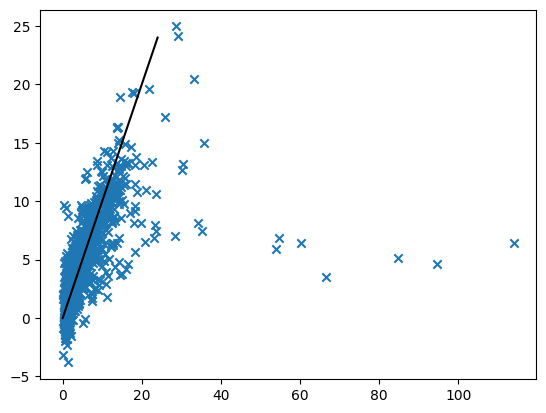

In [136]:
# Find performance on test set
print("Test R-squared: " + str(linear.score(X_test, y_test)))

linear_y_test_pred = linear.predict(X_test)
linear_y_test_pred = linear_y_test_pred*math.sqrt(y_var) + y_mean
linear_test_rmse = mean_squared_error(y_test_unscaled, linear_y_test_pred, squared=False)
print("Test RMSE (Unscaled): " + str(linear_test_rmse))

# Plot result differences (just to see)
linear_test_results = pd.DataFrame({'y_pred': linear_y_test_pred, 'y_true': y_test_unscaled})
linear_fig, linear_plot = plt.subplots()
linear_plot.plot(range(25), color='black')
linear_plot.scatter(linear_test_results.y_true, linear_test_results.y_pred, marker='x')

# L1 Penalty (Lasso Regression)

In [137]:
# Fit model, find coefficients
lasso = linear_model.LassoCV().fit(X_train, y_train)
print("Alpha selected: " + str(lasso.alpha_))
lasso_coefs = pd.DataFrame({'feature': X.columns, 'coef': lasso.coef_})
print(lasso_coefs)

# Find performance on train set
print("Train R-squared: " + str(lasso.score(X_train, y_train)))

lasso_y_train_pred = lasso.predict(X_train)
lasso_y_train_pred = lasso_y_train_pred*math.sqrt(y_var) + y_mean
print("Train RMSE (Unscaled): " + str(mean_squared_error(y_train_unscaled, lasso_y_train_pred, squared=False)))

Alpha selected: 0.0004962574425422115
                          feature      coef
0                      birth_rate -0.036233
1                      median_age  0.037499
2                   median_hh_inc  0.071183
3                   pct_broadband  0.045155
4                     pct_college  0.255580
5                    pct_divorced  0.088965
6      pct_employed_at_government -0.056076
7   pct_employed_at_self_employed  0.045355
8       pct_house_price_250k_500k  0.059992
9      pct_house_price_500k_1mill  0.036855
10        pct_house_price_gt1mill  0.081835
11    pct_housing_single_detached -0.066788
12           pct_in_arts_industry  0.100383
13        pct_in_finance_industry  0.080315
14             pct_in_it_industry  0.054687
15                    pct_insured -0.075025
16          pct_moved_from_abroad  0.028903
17         pct_moved_within_state -0.030090
18        pct_with_libarts_degree  0.052665
19         pct_with_scieng_degree  0.034224
20               total_population  0.0

Test R-squared: 0.3288624562765452
Test RMSE (Unscaled): 4.461864451368749


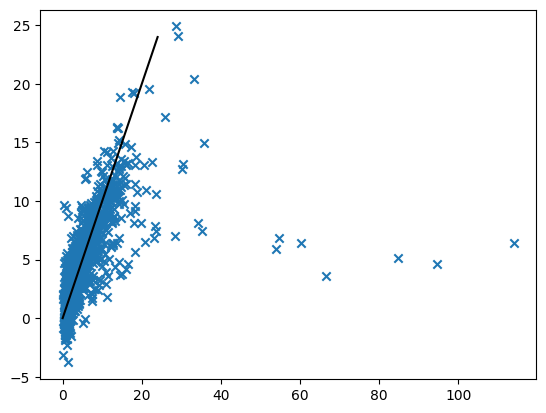

In [138]:
# Find performance on test set
print("Test R-squared: " + str(lasso.score(X_test, y_test)))

lasso_y_test_pred = lasso.predict(X_test)
lasso_y_test_pred = lasso_y_test_pred*math.sqrt(y_var) + y_mean
lasso_test_rmse = mean_squared_error(y_test_unscaled, lasso_y_test_pred, squared=False)
print("Test RMSE (Unscaled): " + str(lasso_test_rmse))

# Plot result differences (just to see)
lasso_test_results = pd.DataFrame({'y_pred': lasso_y_test_pred, 'y_true': y_test_unscaled})
lasso_fig, lasso_plot = plt.subplots()
lasso_plot.plot(range(25), color='black')
lasso_plot.scatter(lasso_test_results.y_true, lasso_test_results.y_pred, marker='x')

# L2 Penalty (Ridge Regression)

In [139]:
# Fit model, find coefficients
ridge = linear_model.RidgeCV().fit(X_train, y_train)
print("Alpha selected: " + str(ridge.alpha_))
ridge_coefs = pd.DataFrame({'feature': X.columns, 'coef': ridge.coef_})
print(ridge_coefs)

# Find performance on train set
print("Train R-squared: " + str(ridge.score(X_train, y_train)))

ridge_y_train_pred = ridge.predict(X_train)
ridge_y_train_pred = ridge_y_train_pred*math.sqrt(y_var) + y_mean
print("Train RMSE (Unscaled): " + str(mean_squared_error(y_train_unscaled, ridge_y_train_pred, squared=False)))

Alpha selected: 10.0
                          feature      coef
0                      birth_rate -0.036603
1                      median_age  0.038030
2                   median_hh_inc  0.071742
3                   pct_broadband  0.045743
4                     pct_college  0.254659
5                    pct_divorced  0.089390
6      pct_employed_at_government -0.056463
7   pct_employed_at_self_employed  0.046026
8       pct_house_price_250k_500k  0.060017
9      pct_house_price_500k_1mill  0.036892
10        pct_house_price_gt1mill  0.081891
11    pct_housing_single_detached -0.067297
12           pct_in_arts_industry  0.100422
13        pct_in_finance_industry  0.080632
14             pct_in_it_industry  0.054911
15                    pct_insured -0.075888
16          pct_moved_from_abroad  0.029351
17         pct_moved_within_state -0.030547
18        pct_with_libarts_degree  0.053032
19         pct_with_scieng_degree  0.034429
20               total_population  0.051638
Train R-squ

Test R-squared: 0.3288770390696997
Test RMSE (Unscaled): 4.461815976357599


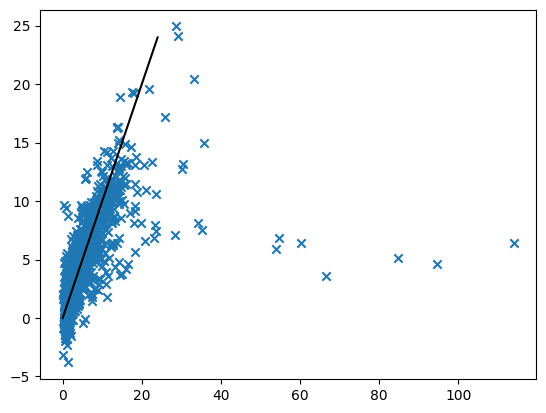

In [140]:
# Find performance on test set
print("Test R-squared: " + str(ridge.score(X_test, y_test)))

ridge_y_test_pred = ridge.predict(X_test)
ridge_y_test_pred = ridge_y_test_pred*math.sqrt(y_var) + y_mean
ridge_test_rmse = mean_squared_error(y_test_unscaled, ridge_y_test_pred, squared=False)
print("Test RMSE (Unscaled): " + str(ridge_test_rmse))

# Plot result differences (just to see)
ridge_test_results = pd.DataFrame({'y_pred': ridge_y_test_pred, 'y_true': y_test_unscaled})
ridge_fig, ridge_plot = plt.subplots()
ridge_plot.plot(range(25), color='black')
ridge_plot.scatter(ridge_test_results.y_true, ridge_test_results.y_pred, marker='x')

# L1 & L2 Penalties (ElasticNet)

In [141]:
# Fit model, find coefficients
en = linear_model.ElasticNetCV().fit(X_train, y_train)
print("Alpha selected: " + str(en.alpha_))
en_coefs = pd.DataFrame({'feature': X.columns, 'coef': en.coef_})
print(en_coefs)

# Find performance on train set
print("Train R-squared: " + str(en.score(X_train, y_train)))

en_y_train_pred = en.predict(X_train)
en_y_train_pred = en_y_train_pred*math.sqrt(y_var) + y_mean
print("Train RMSE (Unscaled): " + str(mean_squared_error(y_train_unscaled, en_y_train_pred, squared=False)))

Alpha selected: 0.0009925148850844232
                          feature      coef
0                      birth_rate -0.036241
1                      median_age  0.037435
2                   median_hh_inc  0.071205
3                   pct_broadband  0.045217
4                     pct_college  0.255237
5                    pct_divorced  0.088873
6      pct_employed_at_government -0.056034
7   pct_employed_at_self_employed  0.045395
8       pct_house_price_250k_500k  0.059998
9      pct_house_price_500k_1mill  0.036890
10        pct_house_price_gt1mill  0.081824
11    pct_housing_single_detached -0.066757
12           pct_in_arts_industry  0.100408
13        pct_in_finance_industry  0.080369
14             pct_in_it_industry  0.054707
15                    pct_insured -0.074920
16          pct_moved_from_abroad  0.028912
17         pct_moved_within_state -0.030082
18        pct_with_libarts_degree  0.052673
19         pct_with_scieng_degree  0.034278
20               total_population  0.0

Test R-squared: 0.32885673815528116
Test RMSE (Unscaled): 4.461883458968527


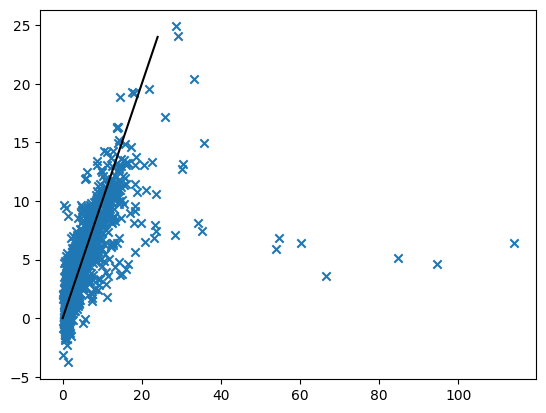

In [142]:
# Find performance on test set
print("Test R-squared: " + str(en.score(X_test, y_test)))

en_y_test_pred = en.predict(X_test)
en_y_test_pred = en_y_test_pred*math.sqrt(y_var) + y_mean
en_test_rmse = mean_squared_error(y_test_unscaled, en_y_test_pred, squared=False)
print("Test RMSE (Unscaled): " + str(en_test_rmse))

# Plot result differences (just to see)
en_test_results = pd.DataFrame({'y_pred': en_y_test_pred, 'y_true': y_test_unscaled})
en_fig, en_plot = plt.subplots()
en_plot.plot(range(25), color='black')
en_plot.scatter(en_test_results.y_true, en_test_results.y_pred, marker='x')

# Errors

In [149]:
results = pd.DataFrame({'type': ['Linear', 'Ridge', 'Lasso', 'ElasticNet'], 'rmse': [linear_test_rmse, ridge_test_rmse, lasso_test_rmse, en_test_rmse]})
results.loc[results['rmse'].idxmin()]

type     Linear
rmse    4.46178
Name: 0, dtype: object

In [148]:
results

,type,rmse
0,Linear,4.461780
1,Ridge,4.461816
2,Lasso,4.461864
3,ElasticNet,4.461883
